In [2]:
import torch
print(torch.__version__)
# sleep(1e4)

2.3.0.dev20240227


In [374]:
import numpy as np
# import datetime
import h5py
import pandas as pd
import random
# import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data import Dataset
# from torch.utils.tensorboard import SummaryWriter
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import time

%matplotlib inline
plt.style.use('fivethirtyeight')

In [4]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [5]:
device

device(type='mps')

In [6]:
def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2    
    return img[  starty:starty + new_height, startx:startx + new_width, :]  

In [7]:
def add_watermark(im, texts, angle = 45):
  # image opening
  w, h = im.size
  font_size = w//8 if h > w else h//8 
  font_size = random.randint(font_size*0.5, font_size*1.5)
  wim = im.copy().rotate(-angle, expand=True).convert("RGBA") #watermark image
  fnt = ImageFont.truetype("/Library/Fonts/Arial Unicode.ttf", int(font_size/2))

  txt_color = (random.randint(0,255), random.randint(0,255), random.randint(0,255), random.randint(50,200))

  txt = Image.new("RGBA", wim.size, (255, 255, 255, 0))
  d = ImageDraw.Draw(txt)
  text_w, text_h = random.randint(w*.25, w*.75), random.randint(h*.25, h*.75)
  for text in texts:
    d.text((text_w, text_h) , text, font=fnt, fill=txt_color)
    text_h += font_size//2
    text_w += random.randint(-font_size//4, font_size//4)
  out = Image.alpha_composite(wim, txt)
  out = out.rotate(angle, expand = True)
  wp, hp = out.size
  sw, sh = (wp-w)//2, (hp-h)//2
  out = out.crop(box = (sw, sh, w+sw, h+sh)).convert("RGB")
  # print(full_path)
  # out.save(output_image_path)
  return out


In [8]:
texts = ["Nihal Arju", "nihal.arju@intel.com"]

In [9]:
def tensor_from_npimage(img):
    return torch.tensor(img, device=device, dtype=torch.float32).\
    permute(2,0,1).view(1,3,128,128) / 255.0


In [10]:
# dataset class

class CoilDataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['coil-100']
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = np.array(self.dataset[str(index)+'.png'])
        # crop to 128x128 square
        img = crop_centre(img, 128, 128)
        pil_img = Image.fromarray(img)
        angle = random.randint(15,80)
        wtr_img = add_watermark(pil_img, texts=texts, angle=angle)
        wtr_img = np.array(wtr_img)
        return tensor_from_npimage(img), tensor_from_npimage(wtr_img)
    
    def plot_image(self, index):
        img = np.array(self.dataset[str(index)+'.png'])
        # crop to 128x128 square
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
    
    def plot_watermarked(self, index):
        img = np.array(self.dataset[str(index)+'.png'])
        # crop to 128x128 square
        img = crop_centre(img, 128, 128)
        pil_img = Image.fromarray(img)
        angle = random.randint(15,80)
        wtr_img = add_watermark(pil_img, texts=texts, angle=angle)
        wtr_img = np.array(wtr_img)
        plt.imshow(wtr_img, interpolation='nearest')

    # def __getitem__(self, index):
    #     if (index >= len(self.dataset)):
    #       raise IndexError()
    #     img = np.array(self.dataset[str(index)+'.png'])
    #     return torch.tensor(img, device=device, dtype=torch.float32) / 255.0
    
    # def plot_image(self, index):
    #     plt.imshow(np.array(self.dataset[str(index)+'.png']), interpolation='nearest')

In [11]:
# orih5 = r"/Users/narju/Documents/code/educative/retouch/coil-100-originals.h5py"
wtr5 = r"/Volumes/termez/data for machine learning/coil-100-watermarked.h5py"
orih5 = r"/Volumes/termez/data for machine learning/coil-100-texts.h5py"

In [12]:
f = h5py.File(orih5)

In [13]:
list(f.keys())

['coil-100']

In [14]:
with h5py.File(orih5,'r') as f_obj:
    print("datasets: ")
    for dset in f_obj:
        print(dset)
    print("keys: ")
    for group in f_obj.keys():
        print(group)

    dataset = f_obj['coil-100']

datasets: 
coil-100
keys: 
coil-100


def add_watermark(im, texts, angle = 45):
  # image opening
  w, h = im.size
  font_size = w//8 if h > w else h//8 
  font_size = random.randint(font_size*0.5, font_size*1.5)
  wim = im.copy().rotate(-angle, expand=True).convert("RGBA") #watermark image
  fnt = ImageFont.truetype("/Library/Fonts/Arial Unicode.ttf", int(font_size/2))

  txt_color = (random.randint(0,255), random.randint(0,255), random.randint(0,255), random.randint(50,200))

  txt = Image.new("RGBA", wim.size, (255, 255, 255, 0))
  d = ImageDraw.Draw(txt)
  text_w, text_h = random.randint(w*.25, w*.75), random.randint(h*.25, h*.75)
  for text in texts:
    d.text((text_w, text_h) , text, font=fnt, fill=txt_color)
    text_h += font_size//2
  out = Image.alpha_composite(wim, txt)
  out = out.rotate(angle, expand = True)
  wp, hp = out.size
  sw, sh = (wp-w)//2, (hp-h)//2
  out = out.crop(box = (sw, sh, w+sw, h+sh)).convert("RGB")
  # print(full_path)
  # out.save(output_image_path)
  return out

texts = ["Nihal Arju", "nihal.arju@intel.com"]

(128, 128, 3)
(128, 128, 3)


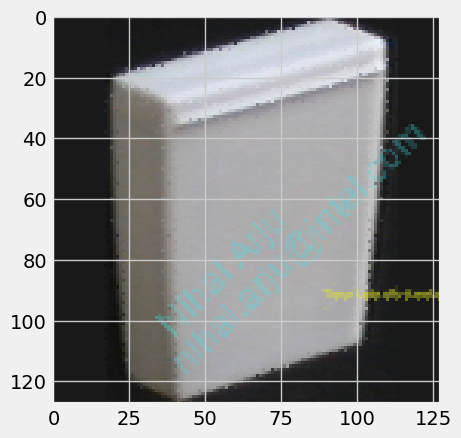

In [15]:
with h5py.File(orih5, 'r') as f_obj:
    dataset = f_obj['coil-100']
    # print("values: ", dataset[:])
    image = np.array(dataset['35.png'])
    print(image.shape)
    # plt.imshow(image, interpolation='none')

with h5py.File(orih5, 'r') as f_obj:
    dataset = f_obj['coil-100']
    # print("values: ", dataset[:])
    npimage = np.array(dataset['35.png'])
    pil_img = Image.fromarray(npimage)
    angle = random.randint(15,80)
    image = add_watermark(pil_img, texts=texts, angle=angle)
    npimage = np.array(image)
    print(npimage.shape)
    plt.imshow(npimage, interpolation='none')

In [16]:
coil_dataset = CoilDataset(orih5)
watermarked_dataset = CoilDataset(wtr5)

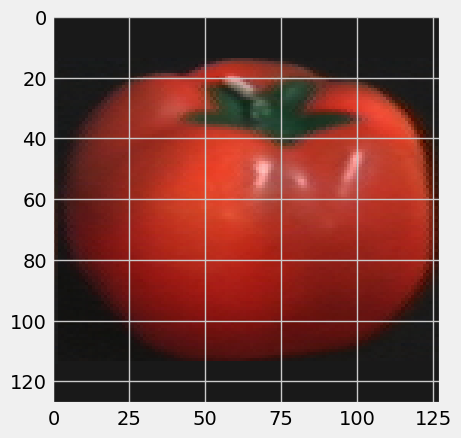

In [17]:
coil_dataset.plot_image(4105)

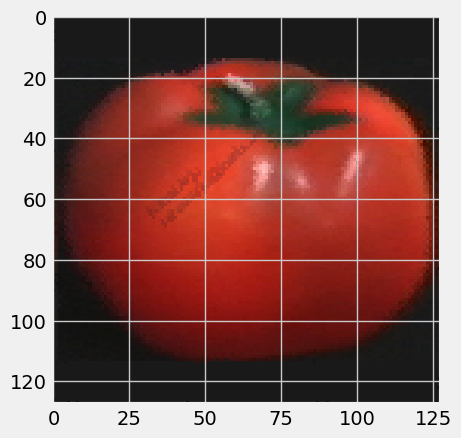

In [18]:
coil_dataset.plot_watermarked(4105)

In [19]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [20]:
# discriminator class
# this one uses fewer parameters but also initially smaller conv filter

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            # expect input of shape (1,3,128,128)
            nn.Conv2d(3, 32, kernel_size=2, stride=1, padding = 1),
            nn.BatchNorm2d(32),
            nn.GELU(),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding = 3),
            nn.BatchNorm2d(64),
            nn.GELU(),
            
            nn.Conv2d(64, 128, kernel_size=8, stride=4, padding = 7),
            nn.BatchNorm2d(128),
            nn.GELU(),
            
            # nn.Conv2d(128, 256, kernel_size=16, stride=8, padding=15),
            # nn.LeakyReLU(0.2),
            
            View(128*19*19),
            nn.Linear(128*19*19, 100),
            nn.Dropout(0.25),
            nn.GELU(),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.lr = 1e-4
        self.optimiser = torch.optim.Adam(self.parameters(), lr=self.lr)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 100 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def count_parameters(self):
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [21]:
D = Discriminator()
D.to(device)
print(D)

image, _ = coil_dataset[10]
print(D(image).shape)
print(D.count_parameters())

/opt/anaconda3/envs/chine310-mps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): Conv2d(64, 128, kernel_size=(8, 8), stride=(4, 4), padding=(7, 7))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU(approximate='none')
    (9): View()
    (10): Linear(in_features=46208, out_features=100, bias=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): GELU(approximate='none')
    (13): Linear(in_features=100, out_features=1, bias=True)
    (14): Sigmoid()
  )
  (loss_function): BCELoss()
)
torch.Size([1])
5179113


In [22]:
# %%time
# # test discriminator can separate real data from random noise
# # move model to cuda device

# for epoch in range(10):
#     cntr = 0
#     for image_data_tensor, wtr_data_tensor in coil_dataset:
#         # real data
#         D.train(image_data_tensor, torch.tensor([1.0], device=device, dtype=torch.float32))
#         D.train(wtr_data_tensor, torch.tensor([0.0], device=device, dtype=torch.float32))
#         cntr += 1
#         if cntr > 2e8:
#             break

        

# Generator Network 

In [382]:
# generator class

class AutoEncoderGenerator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        f1C = 32
        f2C = 64
        f3C = 128

        self.f12 = nn.Sequential(
            nn.Conv2d(3, f1C, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(f1C),
            nn.GELU(),
        )

        self.f23 = nn.Sequential(
            nn.Conv2d(f1C, f2C, kernel_size=4, stride=2, padding=3),
            nn.BatchNorm2d(f2C),
            nn.GELU(),
        )

        self.f34 = nn.Sequential(
            nn.Conv2d(f2C, f3C, kernel_size=8, stride=4, padding=7),
            nn.BatchNorm2d(f3C),
            nn.GELU(),
        )
        
        self.f43t = nn.Sequential(
            nn.ConvTranspose2d(f3C, f2C, kernel_size=8, stride=4, padding=7),
            nn.GELU(),
            nn.Conv2d(f2C, f2C, kernel_size=2, stride=1, padding=2),
            nn.BatchNorm2d(f2C),
            nn.GELU(),
        )

        self.f32t = nn.Sequential(
            nn.ConvTranspose2d(f2C*2, f1C*2, kernel_size=4, stride=2, padding=3),
            nn.GELU(),
            nn.Conv2d(f1C*2, f1C, kernel_size=2, padding=1,),
            nn.BatchNorm2d(f1C),
            nn.GELU(),
        )

        self.f21t = nn.Sequential(
            nn.ConvTranspose2d(f1C*2, 3, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(3),
            nn.Tanh(),
        )

        # create optimiser, simple stochastic gradient descent
        self.lr = 1e-4
        self.optimiser = torch.optim.Adam(self.parameters(), lr=self.lr)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []
        self.loss_function = nn.MSELoss()
        
    def forward(self, inputs):        
        x2 = self.f12(inputs)
        x3 = self.f23(x2)
        x4 = self.f34(x3)
        o3 = torch.cat((self.f43t(x4), x3), dim=1)
        o2 = torch.cat((self.f32t(o3), x2), dim=1)
        o1 = self.f21t(o2) + inputs
        return o1
    
    def train(self, D, inputs, target_image, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        self.loss = self.loss_function(target_image, g_output)*10 + D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 100 == 0):
            self.progress.append(self.loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        self.loss.backward()
        self.optimiser.step()

        pass
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass



# Comments
Here, the MSE from target image is multiplied by 10 because if most of the image has to be distorted to remove the distortion (watermark in this case), it is not worth it. Also it roughly reflects the ratio of the area containing the distortion, vs the total area of the image. (This property is not well generalized)
I also tried training without the adversarial part Discriminator.train(Generator(image), ...)- it reduced image distortion but the reconstruction became lazy (i.e. watermark was still there in this case)

In [383]:
G = AutoEncoderGenerator()
G.to(device)
print(G.count_parameters())

1239241


In [384]:
image,_ = watermarked_dataset[4105]

In [429]:
output = G(image)
print(output.shape)

torch.Size([1, 3, 128, 128])


In [430]:
# D.to(device)
# output = G(image)
# print(output.shape)
D(image)

tensor([1.], device='mps:0', grad_fn=<SigmoidBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


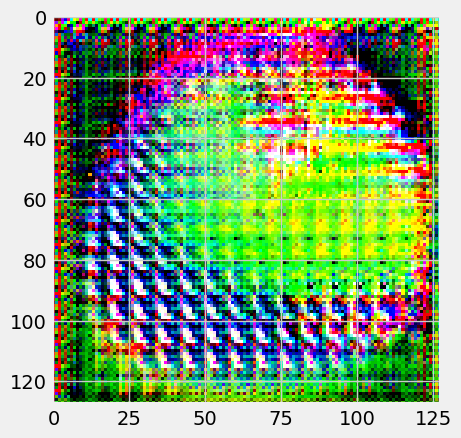

In [431]:
img = output.squeeze().permute(1,2,0).detach().cpu().numpy()
plt.imshow(img)

In [438]:

D.lr = 1e-4
G.lr = 1e-4


In [439]:
%%time 
D.model.train()
# G.model.train()

for epoch in range(100):
  cntr = 0
  
  for image_data_tensor, wtr_data_tensor in coil_dataset:
    # train discriminator on true
    D.train(image_data_tensor, torch.tensor([1.0], device=device, dtype=torch.float32))
    D.train(wtr_data_tensor, torch.tensor([0.0], device=device, dtype=torch.float32))
    # D.train(G(wtr_data_tensor).detach(), torch.tensor([0.0], device=device, dtype=torch.float32))
    # train generator
    G.train(D, wtr_data_tensor, image_data_tensor, torch.tensor([1.0], device=device, dtype=torch.float32))
    cntr += 1
    if (17 < time.localtime().tm_hour < 21) and (time.localtime().tm_wday < 5):
      time.sleep(60)
    if cntr > 5e10:
      break
  
  if epoch%5 == 0: 
    print("epoch = ", epoch, "lr= ", G.lr)
    if epoch != 0:
      D.lr = max(1e-5, D.lr/1.2)
      G.lr = max(1e-5, G.lr/1.2)


counter =  3200000
counter =  3210000
counter =  3220000
epoch =  0 lr=  0.0001
counter =  3230000
counter =  3240000
counter =  3250000
counter =  3260000
counter =  3270000
counter =  3280000
counter =  3290000
counter =  3300000
counter =  3310000
counter =  3320000
counter =  3330000
counter =  3340000
counter =  3350000
counter =  3360000
counter =  3370000
epoch =  5 lr=  0.0001
counter =  3380000
counter =  3390000
counter =  3400000
counter =  3410000
counter =  3420000
counter =  3430000
counter =  3440000
counter =  3450000
counter =  3460000
counter =  3470000
counter =  3480000
counter =  3490000
counter =  3500000
counter =  3510000
counter =  3520000
epoch =  10 lr=  8.333333333333334e-05
counter =  3530000
counter =  3540000
counter =  3550000
counter =  3560000
counter =  3570000
counter =  3580000
counter =  3590000
counter =  3600000
counter =  3610000
counter =  3620000
counter =  3630000
counter =  3640000
counter =  3650000
counter =  3660000
counter =  3670000
epo

KeyboardInterrupt: 

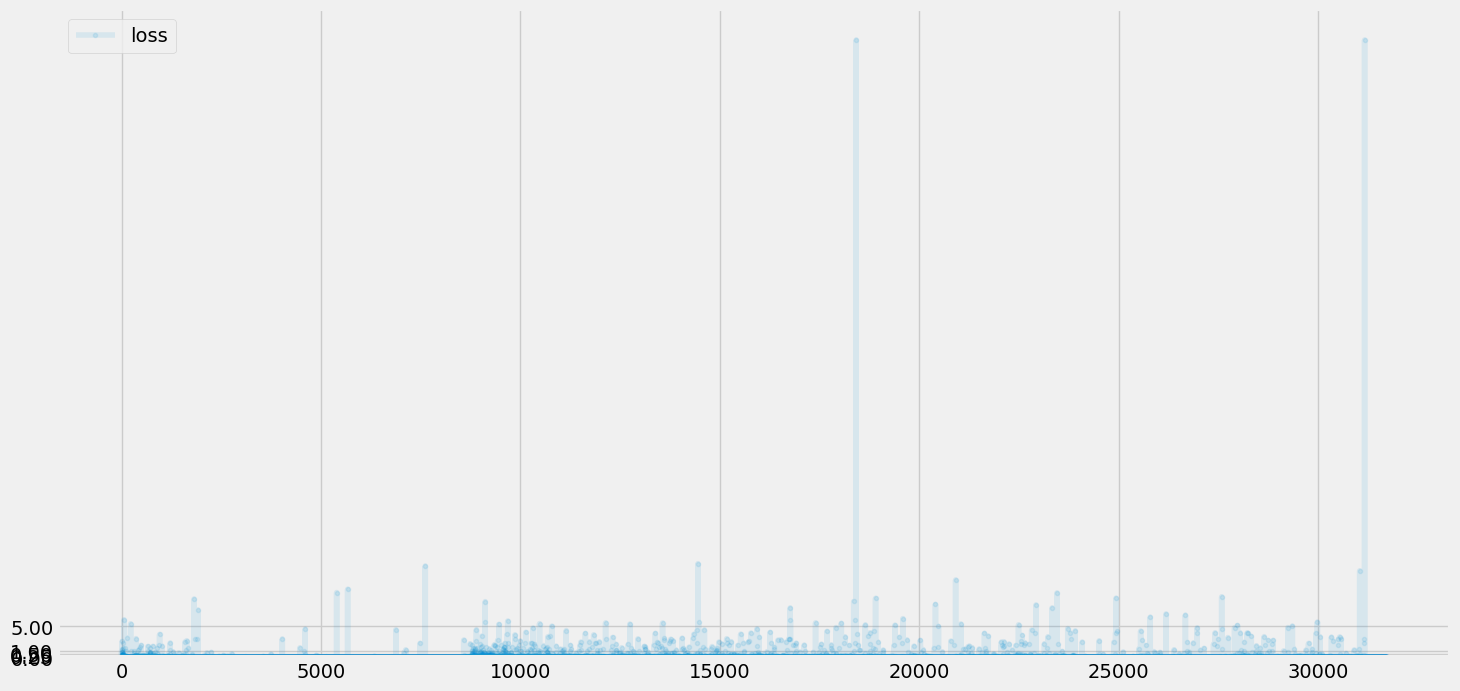

In [378]:
D.plot_progress()

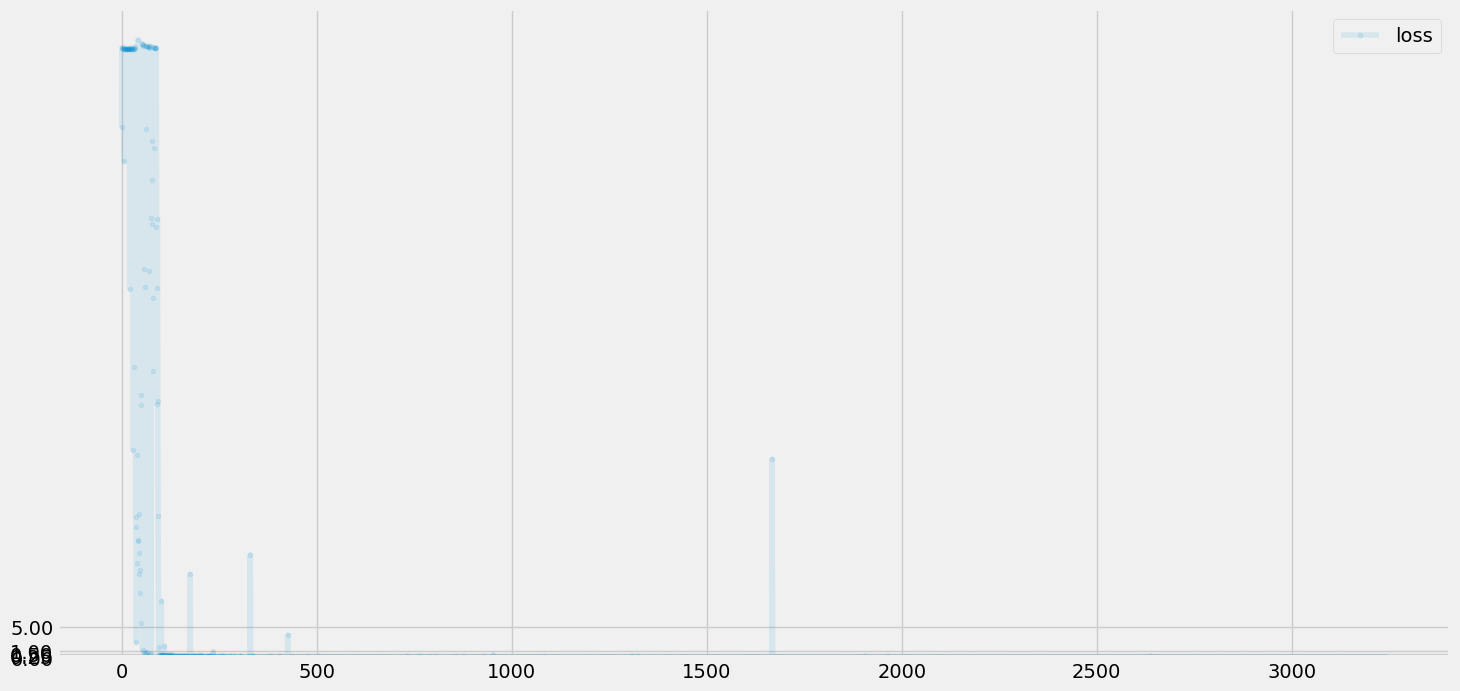

In [440]:
G.plot_progress()

In [106]:
# G.model.eval()
# D.model.eval()
# n = 410 #4105
# image, wimage = coil_dataset[n]
# print(D(image))
# # wimage = watermarked_dataset[n]
# print(D(wimage))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 128, 128])
tensor([1.], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([1.], device='mps:0', grad_fn=<SigmoidBackward0>)


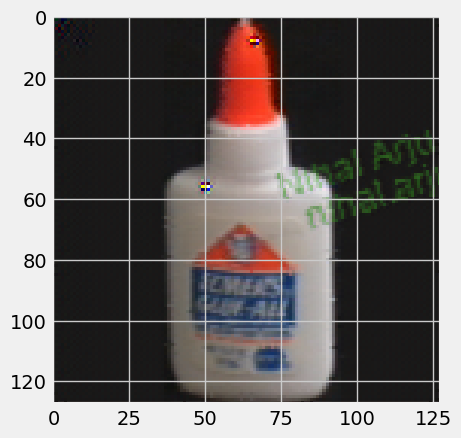

In [445]:
image, wimage = coil_dataset[40]
# D.to(device)
output = G(wimage)
print(output.shape)
cleaned_img = output.squeeze().permute(1,2,0).detach().cpu().numpy()
plt.imshow(cleaned_img)
print(D(image))
print(D(output))

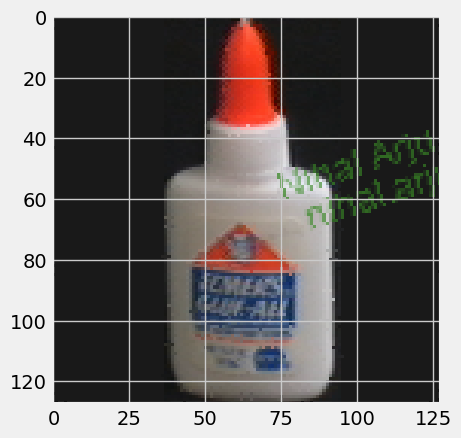

In [446]:
wimagen = wimage.squeeze().permute(1,2,0).detach().cpu().numpy()
plt.imshow(wimagen)

In [447]:
G.progress[-1]

0.009209983982145786

In [448]:
G.progress

[87.13451385498047,
 100.15254211425781,
 100.17511749267578,
 100.08394622802734,
 100.08873748779297,
 100.11431884765625,
 100.06732177734375,
 81.59296417236328,
 100.04231262207031,
 100.19571685791016,
 100.05606079101562,
 100.04032135009766,
 100.05043029785156,
 100.03707122802734,
 100.05533599853516,
 100.02404022216797,
 100.0318603515625,
 100.02619934082031,
 100.02268981933594,
 100.09600830078125,
 100.01619720458984,
 60.5997314453125,
 100.03167724609375,
 100.08085632324219,
 100.03400421142578,
 100.125,
 100.0499496459961,
 100.03700256347656,
 100.0326156616211,
 100.02791595458984,
 33.991127014160156,
 100.20145416259766,
 47.744781494140625,
 100.07279205322266,
 100.05108642578125,
 100.35362243652344,
 23.07270622253418,
 21.4576416015625,
 2.518648147583008,
 15.54050064086914,
 33.268192291259766,
 19.289274215698242,
 101.48786926269531,
 19.047388076782227,
 17.111703872680664,
 23.569673538208008,
 13.714983940124512,
 10.580899238586426,
 14.31289482116

In [48]:
img[127][127]

array([-0.40115356, -0.7905941 , -0.26088104], dtype=float32)

In [60]:
D.lr /= 2
G.lr /= 2

In [61]:
print(G.lr, D.lr)

0.0005 0.0005


In [50]:
G(image).shape

torch.Size([1, 3, 128, 128])

In [345]:
len(G.progress)

5866

In [ ]:
# generator class

# class Generator(nn.Module):

#     def __init__(self):
#         # initialise parent pytorch class
#         super().__init__()
        
#         # define neural network layers
#         self.block = nn.Sequential(
#             # expect input of shape (1,3,128,128)
#             nn.Conv2d(3, 32, kernel_size=2, stride=1),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(0.05),

#             nn.ConvTranspose2d(32, 3, kernel_size=2, stride=1),
#             nn.BatchNorm2d(3),
#             nn.Tanh()
#         )

#         self.model = nn.Sequential(
#             self.block,
#             self.block
#         )

#         self.lr = 1e-2
        
#         # create optimiser, simple stochastic gradient descent
#         self.optimiser = torch.optim.Adam(self.model.parameters(), lr=self.lr)

#         # counter and accumulator for progress
#         self.counter = 0
#         self.progress = []
        
#         pass
    
    
#     def forward(self, inputs):        
#         # simply run model
#         return self.model(inputs) + inputs
    
    
#     def train(self, D, inputs, targets):
#         # calculate the output of the network
#         g_output = self.forward(inputs)
        
#         # pass onto Discriminator
#         d_output = D.forward(g_output)
        
#         # calculate error
#         loss = D.loss_function(d_output, targets) + ((inputs - g_output)**2).mean()

#         # increase counter and accumulate error every 10
#         self.counter += 1
#         if (self.counter % 100 == 0):
#             self.progress.append(loss.item())
#             pass

#         # zero gradients, perform a backward pass, update weights
#         self.optimiser.zero_grad()
#         loss.backward()
#         self.optimiser.step()

#         pass
    
    
#     def plot_progress(self):
#         df = pd.DataFrame(self.progress, columns=['loss'])
#         df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
#         pass
    
#     pass

In [ ]:
# # discriminator class

# class Discriminator(nn.Module):
    
#     def __init__(self):
#         # initialise parent pytorch class
#         super().__init__()
        
#         # define neural network layers
#         self.model = nn.Sequential(
#             # expect input of shape (1,3,128,128)
#             nn.Conv2d(3, 256, kernel_size=8, stride=2),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
            
#             nn.Conv2d(256, 256, kernel_size=8, stride=2),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),
            
#             nn.Conv2d(256, 3, kernel_size=8, stride=2),
#             nn.LeakyReLU(0.2),
            
#             View(3*10*10),
#             nn.Linear(3*10*10, 1),
#             nn.Sigmoid()
#         )
        
#         # create loss function
#         self.loss_function = nn.BCELoss()

#         # create optimiser, simple stochastic gradient descent
#         self.optimiser = torch.optim.Adam(self.parameters(), lr=0.1e-4)

#         # counter and accumulator for progress
#         self.counter = 0;
#         self.progress = []

#         pass
    
    
#     def forward(self, inputs):
#         # simply run model
#         return self.model(inputs)
    
    
#     def train(self, inputs, targets):
#         # calculate the output of the network
#         outputs = self.forward(inputs)
        
#         # calculate loss
#         loss = self.loss_function(outputs, targets)

#         # increase counter and accumulate error every 10
#         self.counter += 1;
#         if (self.counter % 10 == 0):
#             self.progress.append(loss.item())
#             pass
#         if (self.counter % 1000 == 0):
#             print("counter = ", self.counter)
#             pass

#         # zero gradients, perform a backward pass, update weights
#         self.optimiser.zero_grad()
#         loss.backward()
#         self.optimiser.step()

#         pass
    
    
#     def plot_progress(self):
#         df = pd.DataFrame(self.progress, columns=['loss'])
#         df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
#         pass
    
#     pass

In [ ]:
# image, wimage = coil_dataset[7]
# # D.to(device)
# output = G2(wimage)
# print(output.shape)
# cleaned_img = output.squeeze().permute(1,2,0).detach().cpu().numpy()
# plt.imshow(cleaned_img)
# print(D(image))
# print(D(output))

In [ ]:
import os
os.getcwd()

'/Users/narju/Documents/code/educative/retouch/clean_watermark'

In [33]:
# G = AutoEncoderGenerator()
# G.load_state_dict(torch.load( "/Users/narju/Documents/code/educative/retouch/generator with autoencoder 2.pt"))

# D = Discriminator()
# D.load_state_dict(torch.load( "/Users/narju/Documents/code/educative/retouch/discriminator with multi convolutions 2.pt"))

# G.to(device)
# D.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): Conv2d(64, 128, kernel_size=(8, 8), stride=(4, 4), padding=(7, 7))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): GELU(approximate='none')
    (9): View()
    (10): Linear(in_features=46208, out_features=100, bias=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): GELU(approximate='none')
    (13): Linear(in_features=100, out_features=1, bias=True)
    (14): Sigmoid()
  )
  (loss_function): BCELoss()
)

In [351]:
torch.save(D.state_dict(), "/Users/narju/Documents/code/educative/retouch/discriminator with multi convolutions 4.pt")
torch.save(G.state_dict(), "/Users/narju/Documents/code/educative/retouch/generator with autoencoder 4.pt")

In [ ]:
# from transformers import pipeline
# translator = pipeline("translation_en_to_fr")
# #One line of code!
# print(translator("It is easy to translate languages with transformers", max_length=40))

In [59]:
output.max()

tensor(1.9738, device='mps:0', grad_fn=<MaxBackward1>)

In [140]:
# G.progress = []
# D.progress = []

In [109]:
epoch

15

In [276]:
# # generator class

# class AutoEncoderGenerator(nn.Module):
    
#     def __init__(self):
#         # initialise parent pytorch class
#         super().__init__()

#         f1C = 32
#         f2C = 64
#         f3C = 128

#         self.f12 = nn.Sequential(
#             nn.Conv2d(3, f1C, kernel_size=2, stride=1, padding=0),
#             nn.BatchNorm2d(f1C),
#             nn.GELU(),
#         )

#         self.f23 = nn.Sequential(
#             nn.Conv2d(f1C, f2C, kernel_size=4, stride=2, padding=3),
#             nn.BatchNorm2d(f2C),
#             nn.GELU(),
#         )

#         self.f34 = nn.Sequential(
#             nn.Conv2d(f2C, f3C, kernel_size=8, stride=4, padding=7),
#             nn.BatchNorm2d(f3C),
#             nn.GELU(),
#         )
        
#         self.f43t = nn.Sequential(
#             nn.ConvTranspose2d(f3C, f2C, kernel_size=8, stride=4, padding=7),
#             nn.GELU(),
#             nn.Conv2d(f2C, f2C, kernel_size=2, stride=1, padding=2),
#             nn.BatchNorm2d(f2C),
#             nn.GELU(),
#         )

#         self.f32t = nn.Sequential(
#             nn.ConvTranspose2d(f2C*2, f1C*2, kernel_size=4, stride=2, padding=3),
#             nn.GELU(),
#             nn.Conv2d(f1C*2, f1C, kernel_size=2, padding=1,),
#             nn.BatchNorm2d(f1C),
#             nn.GELU(),
#         )

#         self.f21t = nn.Sequential(
#             nn.ConvTranspose2d(f1C*2, 3, kernel_size=2, stride=1, padding=0),
#             nn.BatchNorm2d(3),
#             nn.Tanh(),
#         )

        
#         # create optimiser, simple stochastic gradient descent
#         self.lr = 1e-4
#         self.optimiser = torch.optim.Adam(self.parameters(), lr=self.lr)

#         # counter and accumulator for progress
#         self.counter = 0
#         self.progress = []
#         self.loss_function = nn.MSELoss()
        
    
#     def forward(self, inputs):        
#         x2 = self.f12(inputs)
#         x3 = self.f23(x2)
#         x4 = self.f34(x3)
#         o3 = torch.cat((self.f43t(x4), x3), dim=1)
#         o2 = torch.cat((self.f32t(o3), x2), dim=1)
#         o1 = self.f21t(o2) + inputs
#         return o1
    
    
#     def train(self, D, inputs, target_image, targets):
#         # calculate the output of the network
#         g_output = self.forward(inputs)
        
#         # pass onto Discriminator
#         d_output = D.forward(g_output)
        
#         # calculate error
#         self.loss = self.loss_function(target_image, g_output) + D.loss_function(d_output, targets)

#         # increase counter and accumulate error every 10
#         self.counter += 1
#         if (self.counter % 100 == 0):
#             self.progress.append(self.loss.item())
#             pass

#         # zero gradients, perform a backward pass, update weights
#         self.optimiser.zero_grad()
#         self.loss.backward()
#         self.optimiser.step()

#         pass
    
#     def count_parameters(self):
#         return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
#     def plot_progress(self):
#         df = pd.DataFrame(self.progress, columns=['loss'])
#         df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
#         pass
    
#     pass



In [376]:
G.lr

1.1215665478461518e-05